<a href="https://colab.research.google.com/github/stanleyhuang12/ds542-deep-learning/blob/main/stanley_discussion_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CDSDS 542 - Spring 2026 - Discussion 5


[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DL4DS/fa2026_discussions/blob/main/discussion_05.ipynb)

### Import packages

We are using `livelossplot` to track the training/validation loss and accuracy for this discussion. Please run `pip install livelossplot` if you are using your own computing environment (See: https://pypi.org/project/livelossplot/).

In [1]:
!pip install livelossplot

In [2]:
from livelossplot import PlotLosses

# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### 1. Load the Data
 **CIFAR-10**: One of the most commonly used datasets in deep learning for image classification, contains 60,000 color images, each of size 32×32 pixels, divided into 10 different classes. Each image is small but labeled, making it an ideal dataset for training and testing deep learning models quickly. Unlike larger datasets (like ImageNet), CIFAR-10 can be trained on a laptop GPU within minutes. You can load the dataset directly with `torchvision.datasets.CIFAR10` See: https://www.cs.toronto.edu/~kriz/cifar.html

 Samples of the dataset:

100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


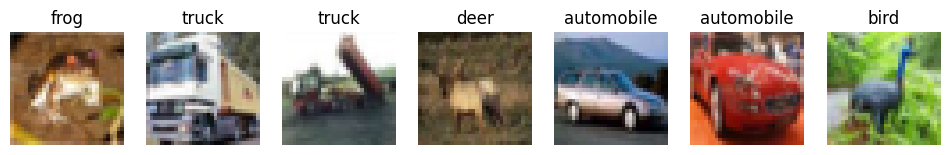

In [3]:
vis_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
classes = vis_set.classes
print("Classes:", classes)
fig, axes = plt.subplots(1, 7, figsize=(12, 5))
for i in range(7):
    img, label = vis_set[i]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(classes[label])
    axes[i].axis("off")
plt.show()

**Data Augmentation**: When training deep learning models, we want them to generalize well — not just memorize the training images. Data augmentation artificially increases training data by applying transformations, such as spatial transformations (changing image position/size/shape), flipping, geometric operations, color and lighting transformations, blurring, and noise. etc. `torchvision.transforms` provides functions for all these operations.

For example:
`transforms.RandomCrop(size, padding=0)`, `transforms.Resize(size)`, `transforms.RandomRotation(degrees)`, ...

Data augmentation to interpolate and create more datas by creating small transformations on each of the image (e.g., flipping, adding noise, change color to make models more robust)

In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_size = int(0.8*len(trainset))
val_size = len(trainset) - train_size
train_ds, val_ds = random_split(trainset, [train_size, val_size]) # split train/val data

Example images after transform:

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


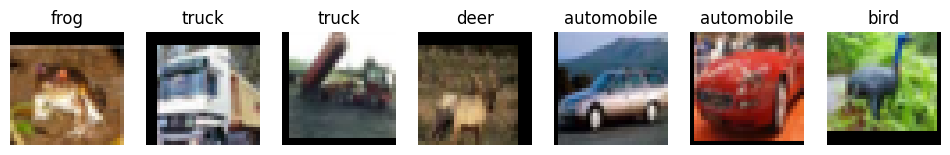

In [5]:
vis_set = trainset
classes = vis_set.classes
print("Classes:", classes)
fig, axes = plt.subplots(1, 7, figsize=(12, 5))
for i in range(7):
    img, label = vis_set[i]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(classes[label])
    axes[i].axis("off")
plt.show()

**DataLoader**:

PyTorch provides two important tools in torch.utils.data:
`Dataset`: A wrapper around your data. It knows how to fetch one sample and its label.
`DataLoader`: Takes a Dataset and helps us load the data in **mini-batches**, shuffle it (important for SGD), and use multiprocessing for speed. Instead of looping through the dataset one image at a time, the DataLoader prepares ready-to-use mini-batches for training. `DataLoader(dataset, batch_size, shuffle)`

`dataset`: Should be `torch.utils.data.dataset` format. Here, we load from a Torch dataset, but usually you have to define the dataset first; each dataset knows how to return (image, label) pairs.
`batch_size`: This controls how many samples are grouped in one batch before being fed to the model. Example: if batch_size=128, each training step uses 128 images instead of just 1. For efficiency, GPUs can process multiple images at once; also, the loss and gradient estimates are less noisy compared to using only 1 sample. Typically, we choose 32, 64, 128, 256 (depending on GPU memory).

`shuffle`: Usually, set `True` for the training set, to ensure that each epoch sees data in a different order, this prevents the model from memorizing the sequence. `False` for validation and test set to keep order fixed ensures reproducibility.

In [7]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)
test_loader  = DataLoader(testset, batch_size=128, shuffle=False)

### 2. Define a Deep Neural Network

Everyone should already know how to train a neural network manually (see Homework 3 - Problem 3), let's try to build a network with PyTorch:

In PyTorch, we usually define a neural network by creating a Python class that inherits from `torch.nn.Module`. This structure keeps models organized and reusable.

- `__init__`: to declare the layers (convolution, linear, batch norm, dropout, etc.).

- `forward`: to define the flow of data through those layers, same as the predict function in your homework 3.

(Optional): helper methods like init_weights to do special setup.

Here I defined 6 6-layer network, and we will talk about these layers in the following lecture. Usually, `Conv2d` is a convolution layer that extracts local features (edges, textures, patterns), `BatchNorm2d` normalizes activations, making training more stable, and `MaxPool2d(2,2)` reduces spatial size (downsampling), keeping only the strongest features. This part makes feature channels grow from 3 → 64 → 128 → 256. And after flattening (from convolutional maps to a vector), these layers combine learned features to make predictions. `fc3` outputs size 10 → one score per CIFAR-10 class.

**Weight initialization**:

When we train a neural network, we use **gradient descent**: $w_{t+1} = w_t - \eta \cdot \nabla L(w_t)$
The **size of the initial weights** strongly affects the values of activations and gradients in early layers, and therefore determines whether training will succeed. Especially when the network is DEEP.

1. Too Small Initialization → Vanishing Gradients

If weights are very close to zero, then outputs of each layer also easily shrink toward zero. After several layers, the activations become almost constant (gradients become nearly zero during backpropagation), weight updates will be tiny, and the network might stop learning.

2. Too Large Initialization → Exploding Gradients

If weights are very large, the outputs of neurons grow quickly. After applying activation functions (like ReLU or sigmoid), they may saturate (sigmoid/tanh) or just blow up in magnitude (ReLU). During backpropagation, gradients multiply through each layer. With large numbers, this can cause gradients to explode, which results in very unstable training (loss oscillates, even NaN values).

3. Good Initialization → Balanced Flow of Information

Usually, we choose weights so that the variance of activations and the variance of gradients stay roughly the same across layers. This avoids signals vanishing or exploding. (e.g., Xavier initialization and Kaiming initialization):

## **Exercise 1:**
Please fill the init_weights with extreme small/large numbers (like 1e-8, 1.0) to simulate training under different situations.

In [10]:
class SimpleCIFARCNN(nn.Module):

    def __init__(self, initition_mode="good"):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(256*4*4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(0.3)

        self.init_weights(initition_mode)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256*4*4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        return self.fc3(x)

    # TODO
    def init_weights(self, mode="good"):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                if mode == "good":
                    nn.init.xavier_uniform_(m.weight)
                elif mode == "small":
                    nn.init.normal_(m.weight, mean=0, std=1e-8)
                elif mode == "big":
                    nn.init.normal_(m.weight, mean=0, std=3)
                else:
                    raise ValueError("mode must be 'good', 'small', or 'big'")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

### 3. Model Training \& Gradients Tracking

Gradients are the learning signal of the model. When we call `loss.backward()`, PyTorch computes gradients for each parameter; these values determine how weights update in gradient descent. By tracking gradients, you can see how the design choices of your model impact learning.
- If the gradient is zero → no update (learning stalls).
- If the gradient is huge → the update is unstable.

`plot_gradients` is to plot the histogram of the gradient during the process. A healthy distribution should be centered around zero and spread out (not collapsing). If the histogram squashes near zero, there are vanishing gradients, and if it spreads too wide, it probably results in exploding gradients.

In [11]:
# This function loops through all trainable parameters of the model(all weights and biases)
# As we talked about last time, .grad stores the gradient of each parameter after backpropagation
# Return a dictionary mapping each layer name → array of gradient values.
def collect_gradients(model):
    grads = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads[name] = param.grad.detach().cpu().view(-1).numpy() # turn into numpy array for plotting
    return grads


def plot_gradients(grad_snapshots, layers_to_plot):

    checkpoints = sorted(grad_snapshots.keys())
    fig, axes = plt.subplots(len(layers_to_plot), len(checkpoints), figsize=(16, 10))

    for row, layer in enumerate(layers_to_plot):
        for col, pct in enumerate(checkpoints):
            ax = axes[row, col] if len(layers_to_plot) > 1 else axes[col]

            if layer in grad_snapshots[pct]:
                grads = grad_snapshots[pct][layer]
                ax.hist(grads, bins=50, alpha=0.7, edgecolor="black")
                ax.set_title(f"{layer} @ epoch {pct}", fontsize=10)
                ax.set_xlabel("Gradient Value")
                ax.set_ylabel("Frequency")
                ax.grid(True, alpha=0.3)

                mean_grad = np.mean(grads)
                ax.axvline(mean_grad, color="r", linestyle="--", linewidth=1, label=f"μ={mean_grad:.2e}")
                ax.legend(fontsize=8)
            else:
                ax.text(0.5, 0.5, "N/A", ha="center", va="center", fontsize=20)
                ax.set_title(f"{layer} @ epoch {pct}", fontsize=10)

    plt.tight_layout()
    plt.show()

Train the model

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device="cuda", num_epochs=30):

    save_epochs = {
        int(num_epochs*0.25): 25,
        int(num_epochs*0.50): 50,
        int(num_epochs*0.75): 75,
        num_epochs: 100
    }

    grad_snapshots = {}
    liveloss = PlotLosses()

    for epoch in range(1, num_epochs + 1):
        logs = {}

        # --- Train ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()

            if epoch in save_epochs:
                grad_snapshots[save_epochs[epoch]] = collect_gradients(model)

            optimizer.step()

            train_loss += loss.item() * len(targets)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * len(targets)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

        # --- Logging ---
        logs['loss'], logs['val_loss'] = train_loss, val_loss
        logs['accuracy'], logs['val_accuracy'] = train_acc, val_acc
        liveloss.update(logs)
        liveloss.send()

        # scheduler.step()
        print(f"Epoch {epoch}/{num_epochs} | Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")

    return grad_snapshots

## **Exercise 2:**

Let's start with a good initialization

Choose appropriate parameters to train the model, with an expected accuracy`>50%`.

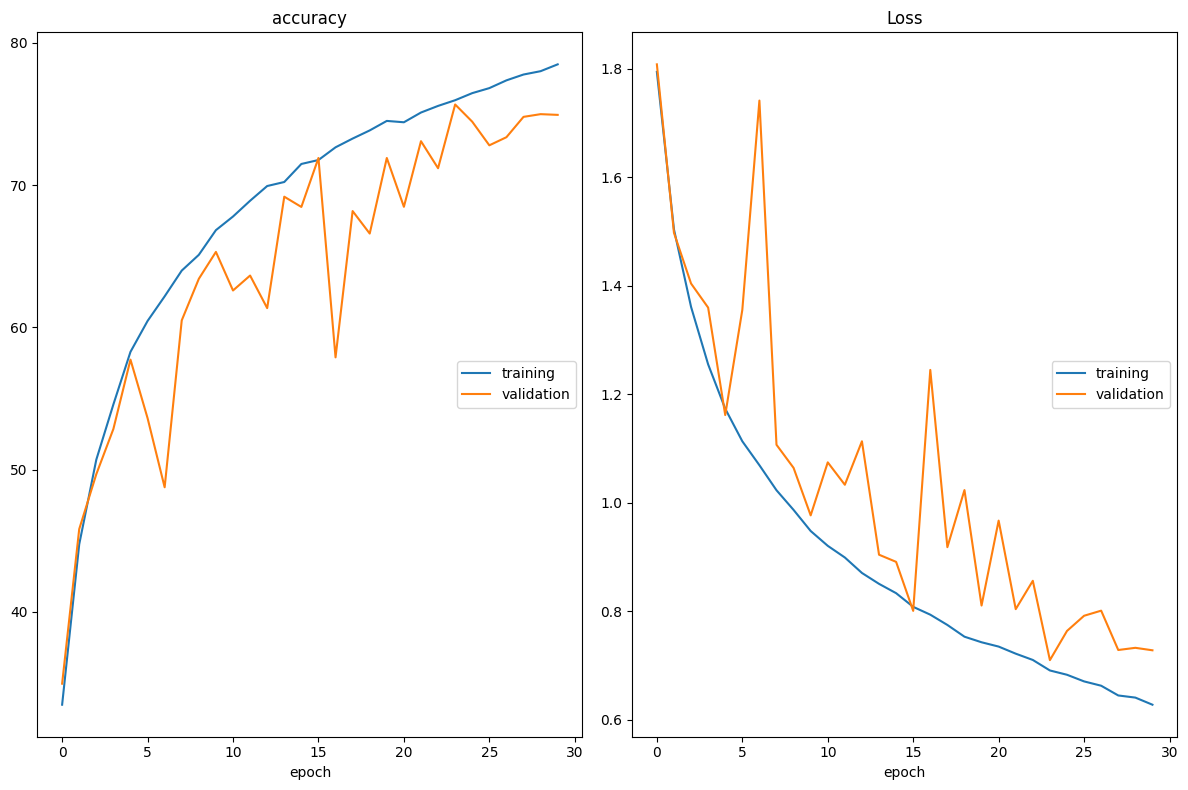

accuracy
	training         	 (min:   33.483, max:   78.480, cur:   78.480)
	validation       	 (min:   34.960, max:   75.660, cur:   74.930)
Loss
	training         	 (min:    0.627, max:    1.794, cur:    0.627)
	validation       	 (min:    0.710, max:    1.808, cur:    0.728)
Epoch 30/30 | Train Acc 78.48% | Val Acc 74.93%


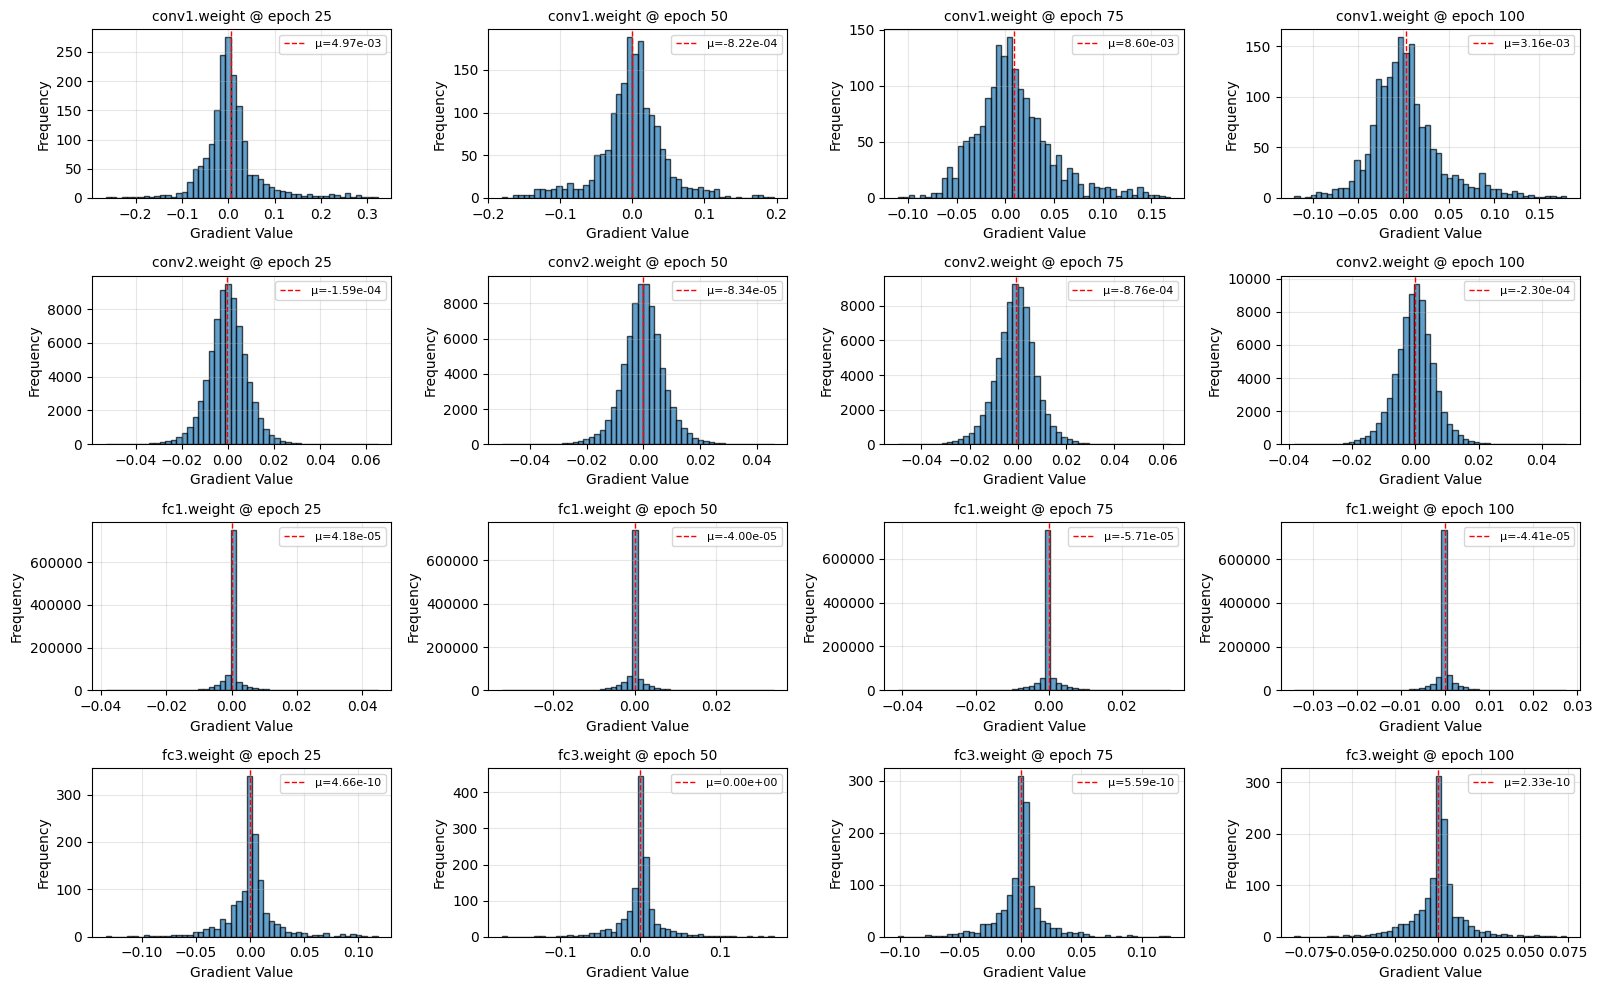

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCIFARCNN("good").to(device)

# TODO: not only __fill__, you can change any of the params, or optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

grad_snapshots = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device=device, num_epochs=30)
plot_gradients(grad_snapshots, layers_to_plot=["conv1.weight", "conv2.weight", "fc1.weight", "fc3.weight"])

In [14]:
# Sample output

## **Exercise 3**:
Try when the model start with bad weight

Run the following cells to compare the gradient histogram. You can also try different set of parameters or use a different optimizor. Notice: it is nomal that Loss becomes `nan` with large weight initialization (**no need of a high accuracy**).

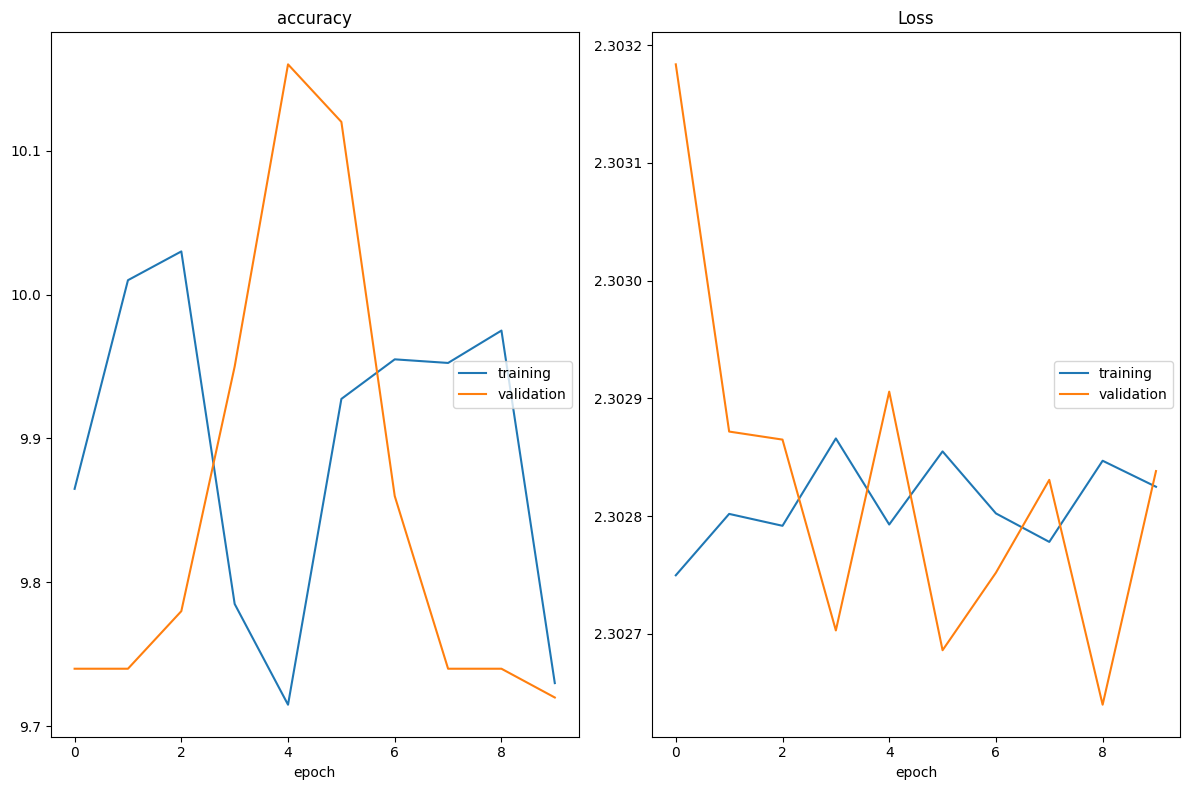

accuracy
	training         	 (min:    9.715, max:   10.030, cur:    9.730)
	validation       	 (min:    9.720, max:   10.160, cur:    9.720)
Loss
	training         	 (min:    2.303, max:    2.303, cur:    2.303)
	validation       	 (min:    2.303, max:    2.303, cur:    2.303)
Epoch 10/10 | Train Acc 9.73% | Val Acc 9.72%


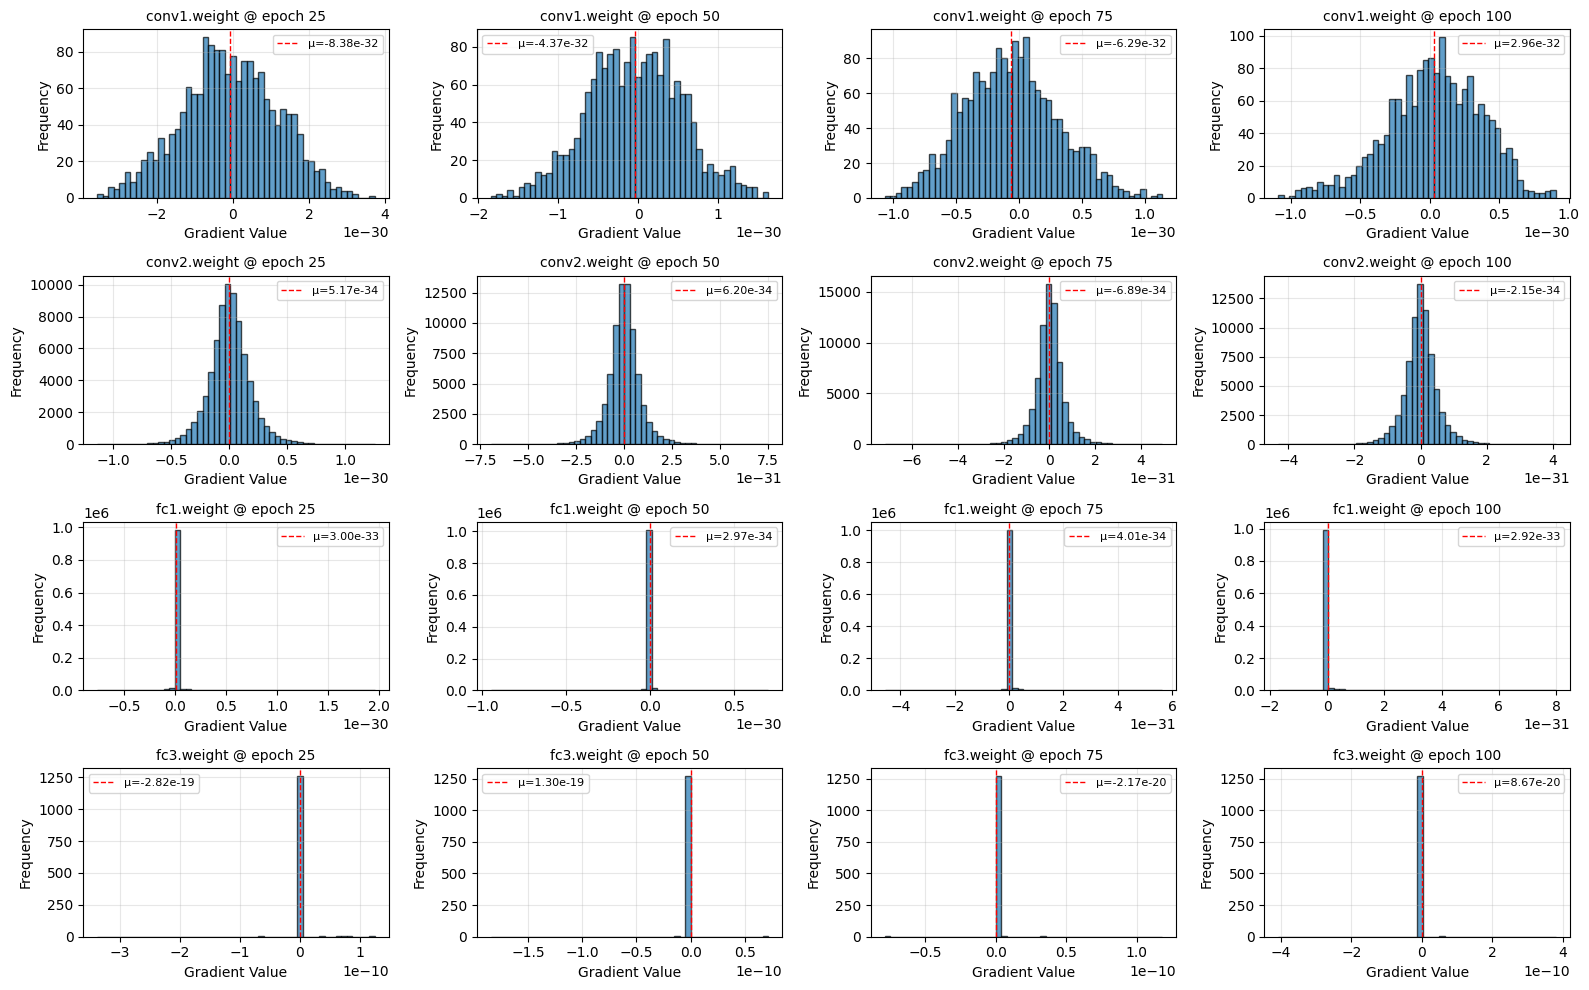

In [15]:
# TODO
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCIFARCNN("small").to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

grad_snapshots = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device=device, num_epochs=10)
plot_gradients(grad_snapshots, layers_to_plot=["conv1.weight", "conv2.weight", "fc1.weight", "fc3.weight"])

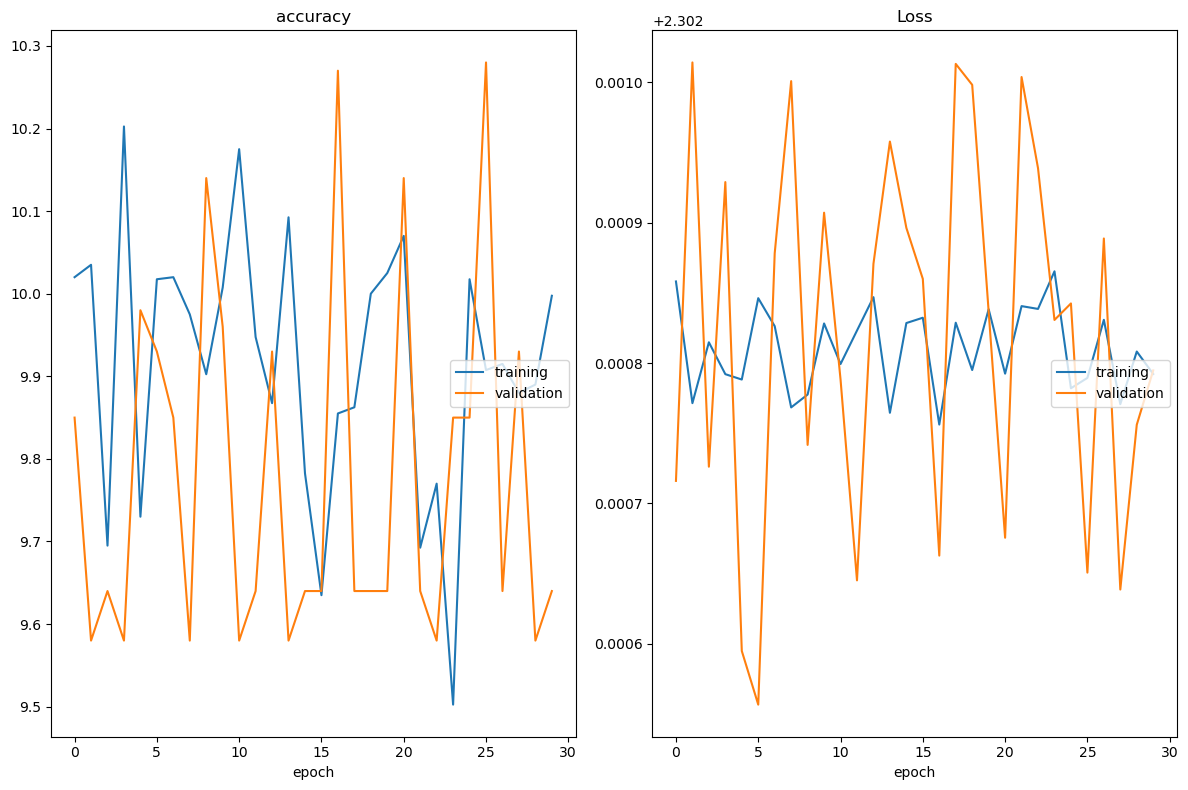

accuracy
	training         	 (min:    9.502, max:   10.203, cur:    9.998)
	validation       	 (min:    9.580, max:   10.280, cur:    9.640)
Loss
	training         	 (min:    2.303, max:    2.303, cur:    2.303)
	validation       	 (min:    2.303, max:    2.303, cur:    2.303)
Epoch 30/30 | Train Acc 10.00% | Val Acc 9.64%


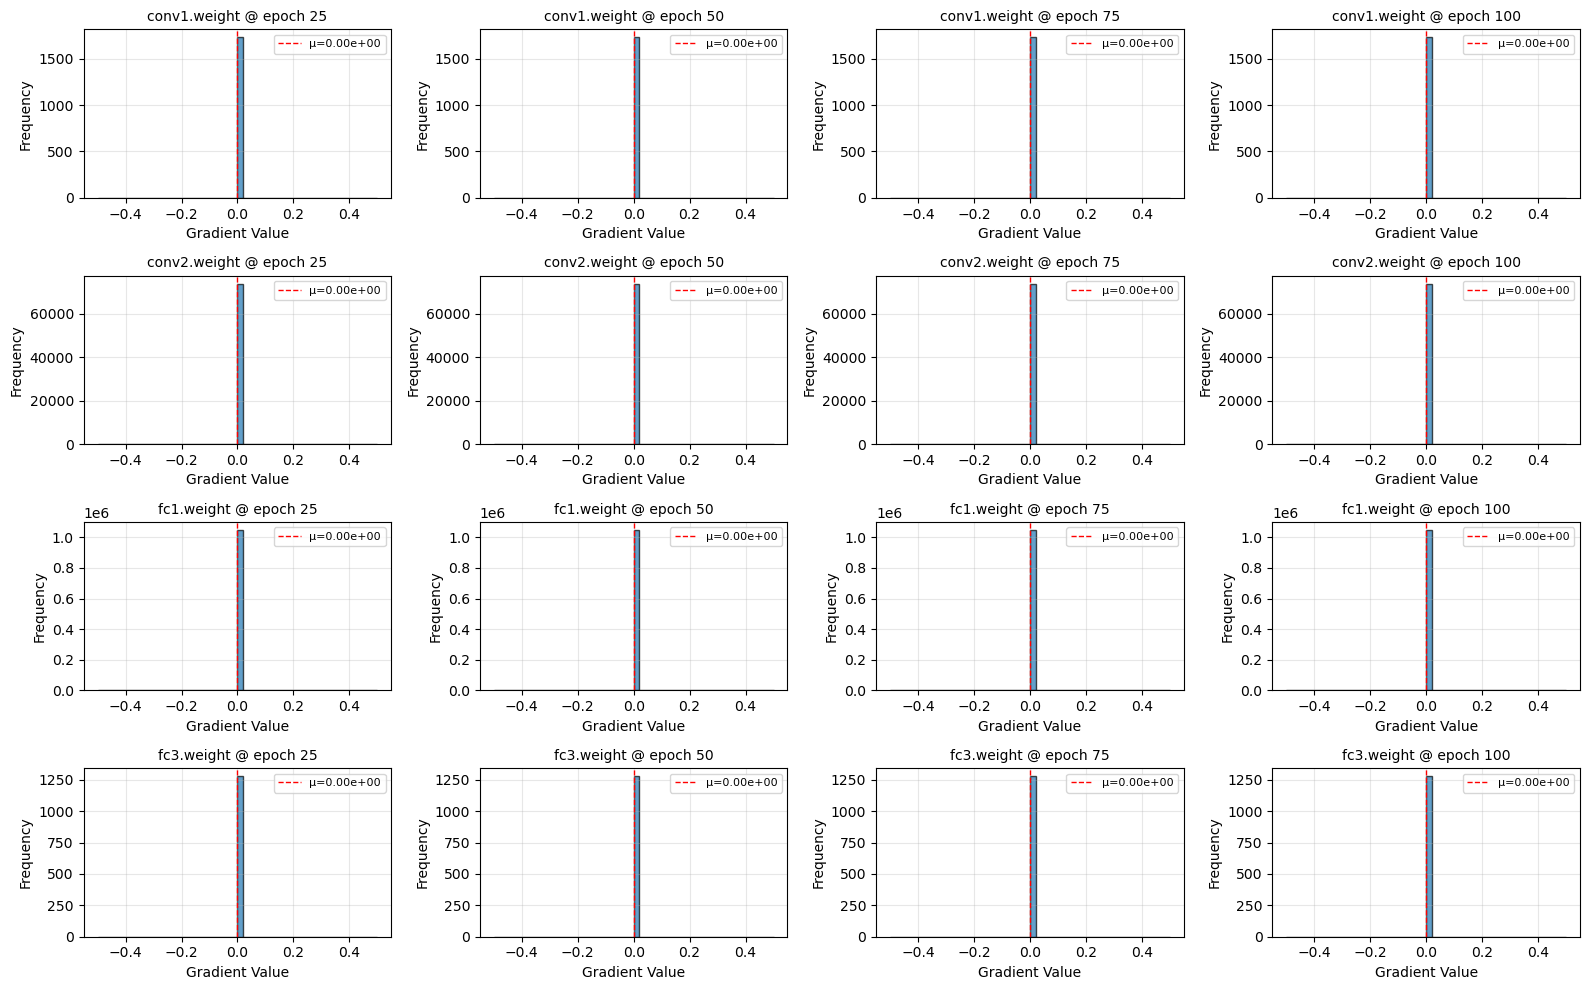

In [ ]:
# Sample output

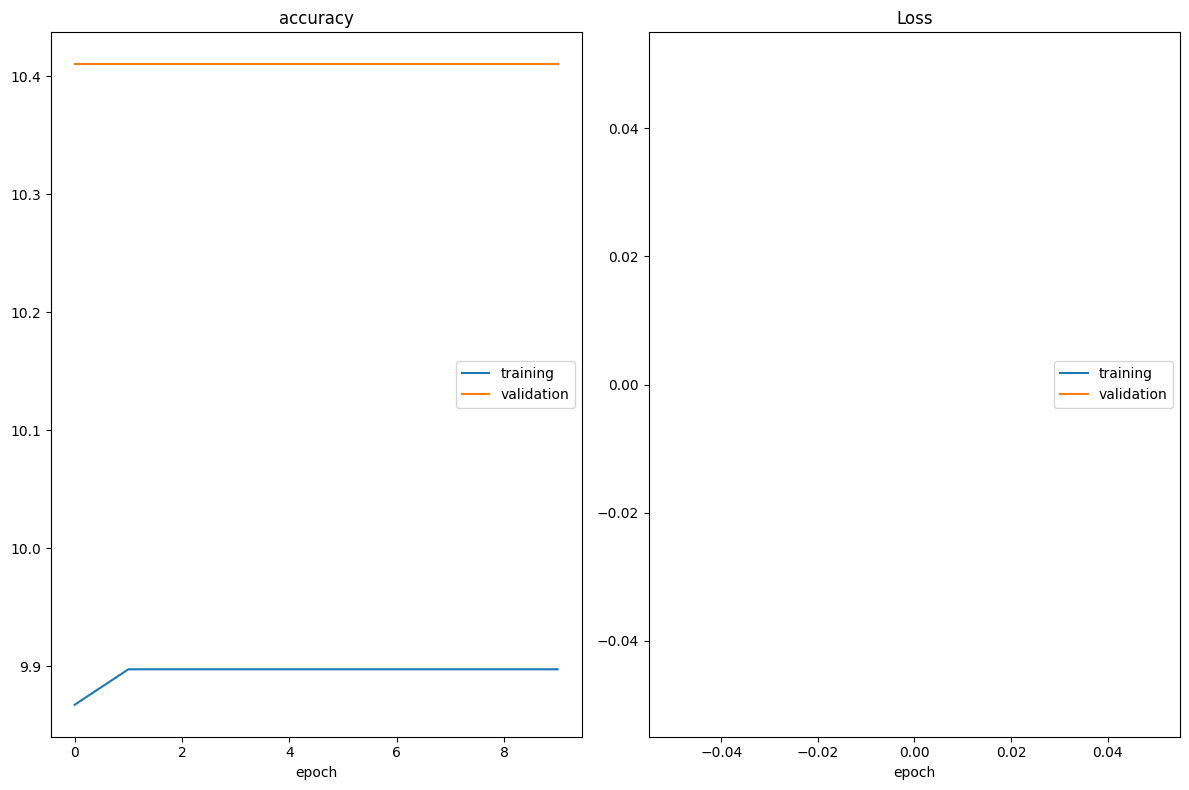

accuracy
	training         	 (min:    9.867, max:    9.898, cur:    9.898)
	validation       	 (min:   10.410, max:   10.410, cur:   10.410)
Loss
	training         	 (min:      nan, max:      nan, cur:      nan)
	validation       	 (min:      nan, max:      nan, cur:      nan)
Epoch 10/10 | Train Acc 9.90% | Val Acc 10.41%


/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:7065: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/usr/local/lib/python3.12/dist-packages/matplotlib/axes/_axes.py:7066: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

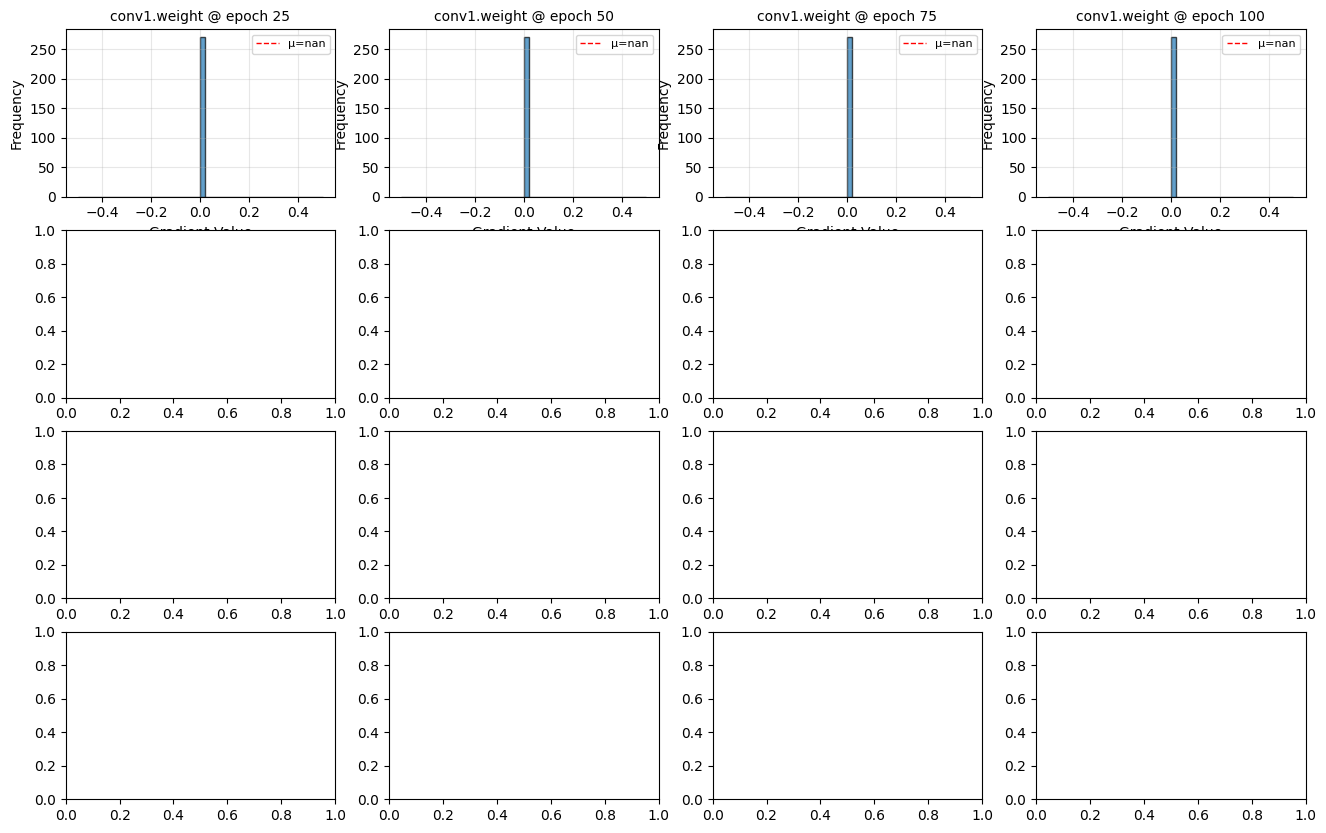

In [16]:
# TODO
# If NaN appears or an error is raised, it indicates gradient explosion
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCIFARCNN("big").to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

grad_snapshots = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device=device, num_epochs=10)
plot_gradients(grad_snapshots, layers_to_plot=["conv1.weight", "conv2.weight", "fc1.weight", "fc3.weight"])